# Data Analysis for CMOS images

## 1. Create the Parameters

### Importing Necessary Libraries and Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import re
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.metrics import log_loss, classification_report , confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, accuracy_score
import scipy.stats

In [3]:
''' Make directory function '''
def make_dir(data_dir):
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

In [4]:
# We create a new directory to store all parameters (Cambiar de directorio para cada CPU)
path_directory = r'C:\Users\erik_\Documents\erik documents\PUCP\Fisica\Altas_Energias_Seminario\Parameters2' 
make_dir(path_directory)

In [5]:
# We define the name of the file in which the data is stored
# main_directory: directory where this notebook is stored
main_directory = r'C:\Users\erik_\Documents\erik documents\PUCP\Fisica\Altas_Energias_Seminario' # Data main directory name
# Prefix of the data we want to analyze (e.g. Y_CDS_z000_f093.npz) 
format_name = 'Y_CDS_z' # format prefix name

# In main_directory are two files: one with the Sr data and other with the BG data:

# We use two data sets, one of the background data and other of Sr source, each has 10 values of z and 500 frames for each z.
dirname_fondo = 'data_fondo_CDS_1000' # Data directory name Background
dirname_Sr =  'data_beta_CDS_1000' # Data directory name Beta particles

# We create a list of the root and file names of all the data to read: 
# In each sublist of the list the first element is the root name: data_beta_CDS_1000, data_fondo_CDS_1000
# In the second element of each sublist is the names of the files for each root name:
# [['...//data_beta_CDS_1000' , [file1,file2,...] , ['...//data_fondo_CDS_1000' , [file1,file2,...]]
root_file_names = [[root,filenames] for root,dirs,filenames in os.walk(main_directory) if (dirname_Sr in root) or (dirname_fondo in root)]

### Create empty lists to store parameters

In [6]:

#################        We create empty lists where we will store parameters from the images         ##################

z_index = 10 # index values for z (10 z values)
background_index = 1 # index values for background (1 background)

# Parameter 1:
ClustersAreas = [[] for i in range(z_index+background_index)] # We will store the clusters size mean of each frame

# Parameter 2:
# We calculate the mean energies in every cluster
MeanEnergiesArray = [[] for i in range(z_index+background_index)]

# Parameter 3:
# We calculate the total energies in every cluster
TotalEnergiesArray =  [[] for i in range(z_index+background_index)]

# Parameter 4: 
# We calculate the max energies (max ADC or Seed) in every cluster
MaxEnergiesArray = [[] for i in range(z_index+background_index)]

# Parameter 5: 
# We extract each cluster in a flat array 
ClustersArray = [[] for i in range(z_index+background_index)]

In [7]:
# Function to calculate the pedestal value, mean of frame plus sigma of frame times a integer
def threshold_val(MeanFrame,SigmaFrame,SigmaMult):
    ''' An iluminated cluster must have an intensity of 'SigmaMult' sigmas over the mean value of the frame '''
    return  MeanFrame + SigmaMult*SigmaFrame

### Iterate over each root and file, create parameters and store them

In [119]:
# We iterate over the root files and files in the directory of exposed data and background data of 1944x2592 images

# Threshold Value in frame:
NumberOfSigmas = 5 # Number of sigmas to consider
minArea = 2 # Minimum Area posible for a cluster
# Start Time
start_time = time.time()

# Extract the root and the file names
for idx,[root,file_names] in enumerate(root_file_names):
    # Iterate over the filenames for one of the 2 roots (BG and Sr)
    for filename in file_names:

        # Consider only the filenames that has 'Y_CDS_z' as part of the string and only for the Sr files
        if format_name in filename:
            # We extract the z index, can be 0,...,9
            char = re.search('CDS_z00(.+?)_f', filename) # Extract the z value of the file
            char = char.group(1)
            
            # Extract the data (images)
            extract_data = np.load(os.path.join(root,filename)) # Load frame
            img = abs(np.array(extract_data.f.arr_0)) 
            
            MeanFrame = img.mean() # Mean of frame
            StdFrame = img.std() # Std of fram
            
            # Threshold Value in frame:
            threshold_value = threshold_val(MeanFrame,StdFrame,NumberOfSigmas)
            
            ######     First Filter     ######
            # Matrix of True and False, True if the ADC is bigger than threshold val, False otherwise:
            True_Value_Matrix = img > threshold_value
            
            # We substract the threshold value to the image so we get only the clusters to identify and the real 
            # energy deposited in the cells
            # img_filtered = np.trunc(img*True_Value_Matrix - threshold_value*True_Value_Matrix)
            
            # In this case the energy has not been modified by the threhold value
            img_filtered = np.trunc(img*True_Value_Matrix)
            img_filtered8b = np.uint8(img_filtered)
            
            # To identify the cluster we apply a binary threshold filter, 255 for the clusters are and 0 elsewhere
            ret, thresh = cv2.threshold(img_filtered8b,0,255,cv2.THRESH_BINARY) # Thresh is the binary matrix
            
            # Cluster identification: NumClusters = Number of clusters, stats(ycoord,xcoord,height,width,cluster area) 
            #                         of each cluster in frame
            NumClusters, labels , stats, centroids = cv2.connectedComponentsWithStats(thresh)
            
            ######     Second Filter     ######
            # We only consider clusters with area bigger than 2 cells, we assume that the energy deposited in 2 
            # consecutive pixels is not relevant

            TrueAreas = stats.T[cv2.CC_STAT_AREA][1:] > minArea # True and False matrix where True values are 
                                                                # from the areas > 2.
            
            #######    Areas of all clusters in a given frame    #######   
            # The area of all clusters size(area) in a given frame (Multiplicity)
            ClustersArea = stats.T[cv2.CC_STAT_AREA][1:][TrueAreas] # Array
            
            NumberOfClusters = len(ClustersArea) # Number of clusters only considering area > 2 
            
            #######    Parameter 1    #######
            ClustersAreas[int(char) + idx*z_index].append(ClustersArea)
            
            # Coordinates of all clusters
            x_coords = stats.T[cv2.CC_STAT_LEFT][1:][TrueAreas] #  Left coordinate of square cluster grid
            y_coords = stats.T[cv2.CC_STAT_TOP][1:][TrueAreas] # Top coordinate of square cluster grid
            width = stats.T[cv2.CC_STAT_WIDTH][1:][TrueAreas] # width values of each cluster
            height = stats.T[cv2.CC_STAT_HEIGHT][1:][TrueAreas] # height values of each cluster
            
            # We create 3 fixed size arrays where we will store the mean energies, total energy and max energy (seed) from each
            # cluster:
            
            #######    Parameter 2    #######
            MeanEnergies = np.ones(NumberOfClusters ,dtype = np.float64) # mean energies of the clusters
            
            #######    Parameter 3    #######
            TotalEnergies = np.ones(NumberOfClusters, dtype = np.float64) # Total energies of the clusters
            
            #######    Parameter 4    #######
            MaxEnergies = np.ones(NumberOfClusters , dtype = np.float64) # Max energies of the clusters (seed)
            
            #######    Parameter 5    #######
            cluster_images = []
            
            # We iterate over all clusters detected in the frame
            for i in range(NumberOfClusters):
                
                # We extract the subframe (cluster coordinates) from the filtered image, the image substracted by the threshold value
                cluster =  img_filtered8b[y_coords[i] : y_coords[i] + height[i] , x_coords[i] : x_coords[i] + width[i]] 
                
                TotalE = cluster.sum() # Total energy from a given cluster in ADC units
                Seed = cluster.max() # Max energy in a given cluster in ADC units
                MeanE = TotalE/ClustersArea[i] # Mean energy from a given cluster in ADC units
                
                # Store in given arrays
                TotalEnergies[i] = TotalE 
                MaxEnergies[i] = Seed
                MeanEnergies[i] = MeanE
                cluster_images.append(np.array(cluster).flatten())
                
            # We now take the mean or max form MeanEnergies, TotalEnergies or MaxEnergies:
            
            #######    Parameter 2    #######
            MeanEnergiesArray[int(char) + idx*z_index].append(MeanEnergies)
            
            #######    Parameter 3    #######
            TotalEnergiesArray[int(char) + idx*z_index].append(TotalEnergies)
            
            #######    Parameter 4    #######
            MaxEnergiesArray[int(char) + idx*z_index].append(MaxEnergies)
            
            #######    Parameter 5    #######
            ClustersArray[int(char) + idx*z_index].append(cluster_images)

# Print the execution time
end_time = time.time()
print('Total execution time: ',(end_time-start_time)/60.)

Total execution time:  22.11493198076884


In [120]:
# We save all the arrays in the new directory with different file names:

parameters_names = ['ClustersArea', 'ClusterMeanEnergies','ClusterTotalEnergies','ClusterMaxEnergies','ClustersImages']
 
parameters_data = [ClustersAreas,MeanEnergiesArray,TotalEnergiesArray ,MaxEnergiesArray ,ClustersArray]

for idx,param in enumerate(parameters_names):
    np.save(os.path.join(path_directory,param+'.npy'),parameters_data[idx])


## 2. Read parameters data, plot distributions and relations

### Extract Data Function 

In [8]:
def extract_data(parameters_directory):
    ''' Input: Directory where the .npy data parameters are stored '''
    # parameters_directory = 'Parameters' or 'Parameters2'
    data_dict = {}
    for filename in os.listdir(parameters_directory):
        name = re.search('(.+?).npy', filename) # Extract the name of the parameter
        name = name.group(1)
        print(os.path.join(parameters_directory,filename))
        data = np.load(os.path.join(parameters_directory,filename),allow_pickle=True)
        data_dict[name] = data #Store the parameter data in a dictionary where the key is the parameter name and the value is the data list
    return data_dict

In [9]:
# Extract the parameters data in a dictionary
data_dictionary = extract_data('Parameters2')

Parameters2\ClusterMaxEnergies.npy
Parameters2\ClusterMeanEnergies.npy
Parameters2\ClustersArea.npy
Parameters2\ClustersImages.npy
Parameters2\ClusterTotalEnergies.npy


In [10]:
# We create the x array names for plotting data
zetas = ['z00'+str(i) for i in range(10)] # Create a list of strings of each z distance
zetas.append('BG') # Add BG string
zeta_repeat = [ item for item in zetas for repetitions in range(500) ] # Create a list of strings of each z distance repeated 500 times

### Flat arbitrary array size

In [11]:
def flatten(items, seqtypes=(list, tuple)):
    for i, x in enumerate(items):
        while i < len(items) and isinstance(items[i], seqtypes):
            items[i:i+1] = items[i]
    return items

### Plot Distributions Function

In [12]:
def plot_set_of_histograms(list_of_data,number_of_bins,title,x_name,labels):
    ''' Plot the distributions of a parameter values:
    - list_of_data: An array containing in each element all 500 data from each parameter 
                    (Ex.: list_of_data_VarianceFrames = [dataZ0,dataZ1,...,dataBG])
    - number_of_bins: An array where each element is the number of bins to consider for each distribution.
    - title: Title of plot
    - x_name: Parameter Name 
    - labels: list of z distances to consider (Ex. ['Z0','Z1',...,'BG'])'''
    
#     colors = ['k','tab:brown','b','g','r','c','m','y','tab:gray','tab:orange']
    colors2 = ['tab:orange','g','k','tab:brown','b','r','c','m','y','tab:gray',(0.1,0.5,0.9)]
    plt.figure(figsize=[11,9])
    edges_min = []
    edges_max = []
    for idx,element in enumerate(list_of_data):
        hist,bin_edge = np.histogram(element , bins = number_of_bins[idx] , density=True)
        width=np.diff(bin_edge)[0]
        plt.step(bin_edge[1:],hist, linestyle = '-', linewidth = 2 , color = colors2[idx],alpha=0.6)
#         plt.bar(bin_edge[:-1], hist,color=colors2[idx],edgecolor=colors2[idx],width=width , alpha=0.2 , label = labels[idx])
#         kwargs = dict()
        plt.hist(element, histtype='stepfilled', alpha=0.2, density=True, bins=number_of_bins[idx],label=labels[idx],
                 color=colors2[idx])
#         plt.hist(element, histtype='bar', alpha=0.4, density=True, bins=number_of_bins,label=labels[idx],rwidth=0.8)
        edges_min.append(min(bin_edge))
        edges_max.append(max(bin_edge))
    plt.xlim(min(edges_min), max(edges_max))
    plt.xlabel('ADC ' + x_name,fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=15)
    plt.title(title,fontsize=15)
    plt.show()

### Create flatten dictionary 

In [13]:
flatten_data_dictionary = {}

for key in data_dictionary:
    
    if key !=  'ClustersImages':
        print(key)
        AuxList = []
        for lists in data_dictionary[key]:
            flattenlist = flatten([elem.tolist() for elem in lists.tolist()])
#             print(len(flattenlist))
            AuxList.append(np.array(flattenlist))
        flatten_data_dictionary[key] = np.array(AuxList)

ClusterMaxEnergies
ClusterMeanEnergies
ClustersArea
ClusterTotalEnergies


In [14]:
for key in flatten_data_dictionary:
    print(key)

ClusterMaxEnergies
ClusterMeanEnergies
ClustersArea
ClusterTotalEnergies


## Visualize Parameters Relations

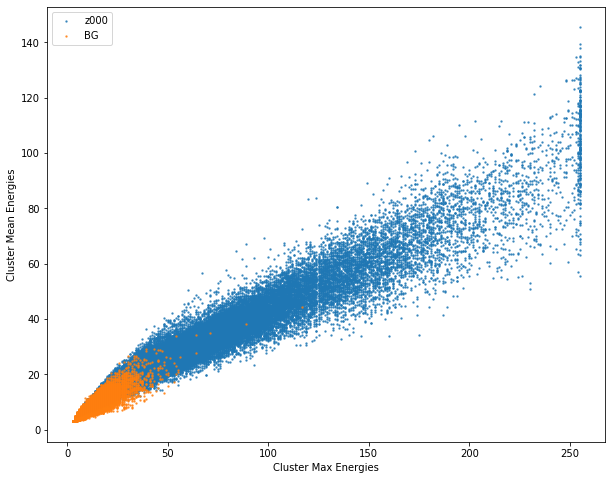

In [15]:
plt.figure(figsize=(10,8))
indexes = range(len(zetas))
for idx,TotalE,AreaC,Zet in zip(indexes,flatten_data_dictionary['ClusterMaxEnergies'],flatten_data_dictionary['ClusterMeanEnergies'],zetas):
    
    if idx == 0 or idx == 10:
#         break
        plt.scatter(TotalE,AreaC,s=2,label=Zet,alpha = 0.7)

plt.xlabel('Cluster Max Energies')
plt.ylabel('Cluster Mean Energies')
plt.legend()
plt.show()

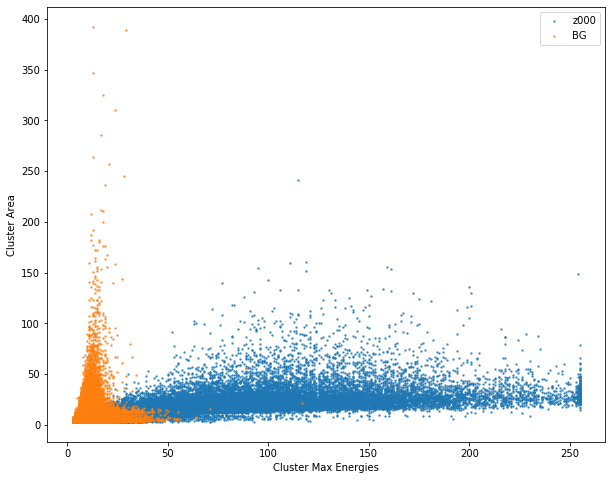

In [16]:
plt.figure(figsize=(10,8))
indexes = range(len(zetas))
for idx,TotalE,AreaC,Zet in zip(indexes,flatten_data_dictionary['ClusterMaxEnergies'],flatten_data_dictionary['ClustersArea'],zetas):
    
    if idx == 0 or idx == 10:
#         break
        plt.scatter(TotalE,AreaC,s=2,label=Zet,alpha = 0.7)

plt.xlabel('Cluster Max Energies')
plt.ylabel('Cluster Area')
plt.legend()
plt.show()

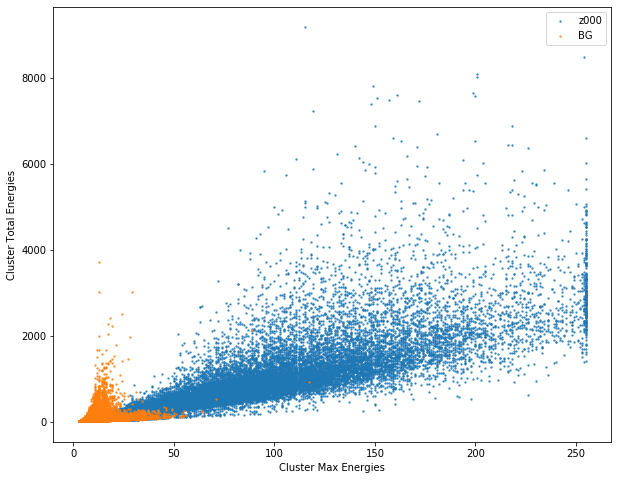

In [17]:
plt.figure(figsize=(10,8))
indexes = range(len(zetas))
for idx,TotalE,AreaC,Zet in zip(indexes,flatten_data_dictionary['ClusterMaxEnergies'],flatten_data_dictionary['ClusterTotalEnergies'],zetas):
    
    if idx == 0 or idx ==10:
#         break
        plt.scatter(TotalE,AreaC,s=2,label=Zet,alpha = 0.7)

plt.xlabel('Cluster Max Energies')
plt.ylabel('Cluster Total Energies')
plt.legend()
plt.show()

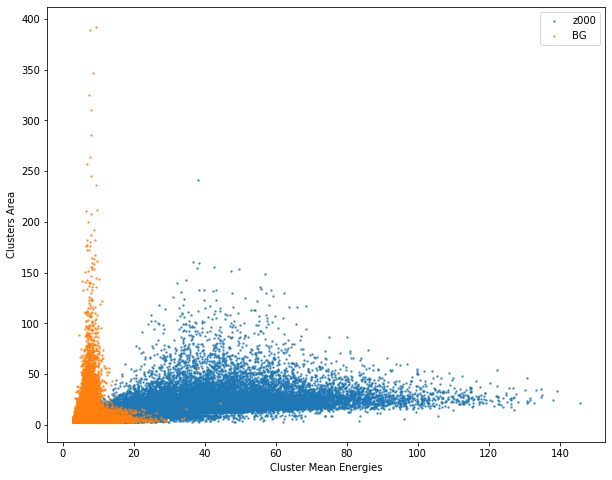

In [18]:
plt.figure(figsize=(10,8))
indexes = range(len(zetas))
for idx,TotalE,AreaC,Zet in zip(indexes,flatten_data_dictionary['ClusterMeanEnergies'],flatten_data_dictionary['ClustersArea'],zetas):
    
    if idx == 0 or idx == 10:
#         break
        plt.scatter(TotalE,AreaC,s=2,label=Zet,alpha = 0.7)

plt.xlabel('Cluster Mean Energies')
plt.ylabel('Clusters Area')
plt.legend()
plt.show()

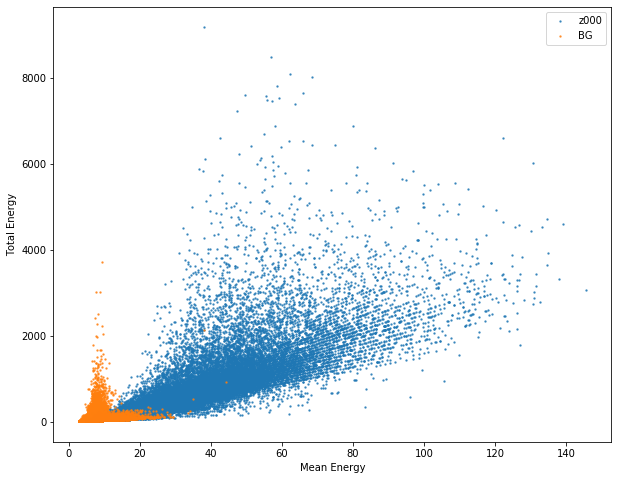

In [19]:
plt.figure(figsize=(10,8))
indexes = range(len(zetas))
for idx,TotalE,AreaC,Zet in zip(indexes,flatten_data_dictionary['ClusterMeanEnergies'],flatten_data_dictionary['ClusterTotalEnergies'],zetas):
    
    if idx == 0 or idx == 10:
#         break
        plt.scatter(TotalE,AreaC,s=2,label=Zet,alpha = 0.7)

plt.xlabel('Mean Energy')
plt.ylabel('Total Energy')
plt.legend()
plt.show()

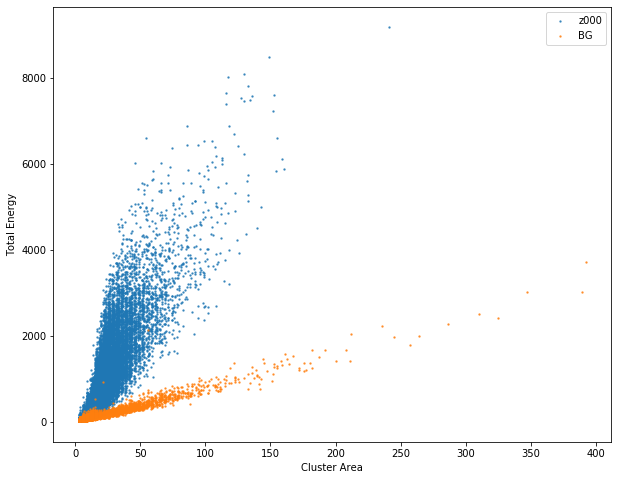

In [20]:
plt.figure(figsize=(10,8))
indexes = range(len(zetas))
for idx,TotalE,AreaC,Zet in zip(indexes,flatten_data_dictionary['ClustersArea'],flatten_data_dictionary['ClusterTotalEnergies'],zetas):
    
    if idx == 0 or idx == 10:
#         break
        plt.scatter(TotalE,AreaC,s=2,label=Zet,alpha = 0.7)

plt.xlabel('Cluster Area')
plt.ylabel('Total Energy')
plt.legend()
plt.show()

In [21]:
def flatten_array_level1(input_array):
    aux_array = []
    for elem in input_array:
        aux_array += list(elem)
    return np.array(aux_array)  

## 3. Create the supervised models classifiers 

### We create the dataframe of the 5500 frames and each frame's parameters

In [21]:
z_index = 10 # number of z distances  
datalengths = [len(i) for i in flatten_data_dictionary['ClustersArea']]  # Number of data per class 

# We create the main classes array for creating dataframe
z_idx = ['z'+str(i) for i in range(z_index)]
z_idx.append('BG')

# Class labels with 5500 elements 500 for each class
class_labels = [z_idx[idx] for idx,length in enumerate(datalengths) for i in range(length)]

# Store all classes in main dataframe
data_frame = pd.DataFrame({'Class':class_labels})

# Store the parameters in dataframe
for key in flatten_data_dictionary:
    data_frame[key] = flatten_array_level1(flatten_data_dictionary[key])

print(data_frame)

        Class  ClusterMaxEnergies  ClusterMeanEnergies  ClustersArea  \
0          z0                 7.0             6.333333             3   
1          z0                 9.0             7.500000             4   
2          z0                 7.0             6.333333             3   
3          z0                16.0             9.333333             3   
4          z0                19.0            13.250000             4   
...       ...                 ...                  ...           ...   
3255354    BG                11.0             8.666667             3   
3255355    BG                 8.0             7.500000             4   
3255356    BG                14.0             9.000000             8   
3255357    BG                 9.0             7.333333             3   
3255358    BG                13.0            10.000000             3   

         ClusterTotalEnergies  
0                        19.0  
1                        30.0  
2                        19.0  
3      

## First approach 

#### The first approach will consist in making 4 kind of supervised classifiers between Z0 and BG (Logistic, Decision Tree, KNN, and SVM). The method will consist in 2 classes (BG and Signal) and the model must classify it correctly, we will vary each models parameters to fit the data with less error and evaluate at least two metrics for each model. 

#### We will consider only Z0 and BG, so we must remove all extra data. Then, as Z0 has less data than BG, we will consider an amount of data from BG equal to the size of Z0.

In [22]:
#  Extract the indices to drop from the dataframe
count = 0
indices_list = []
for idx,elem in enumerate(z_idx):
    count +=  class_labels.count(elem)
    if idx == 0 or idx == 9:
        indices_list.append(count)

In [23]:
filtered_dataframe = data_frame.drop(data_frame.index[indices_list[0]:indices_list[1]])

In [24]:
filtered_dataframe[indices_list[0]-5:indices_list[0]+5] # We stay with the data of z0 and BG

,Class,ClusterMaxEnergies,ClusterMeanEnergies,ClustersArea,ClusterTotalEnergies
167912,z0,8.0,8.000000,3,24.0
167913,z0,17.0,14.000000,4,56.0
167914,z0,13.0,11.250000,4,45.0
167915,z0,11.0,9.000000,6,54.0
167916,z0,9.0,8.250000,4,33.0
2811904,BG,4.0,4.000000,3,12.0
2811905,BG,5.0,4.666667,3,14.0
2811906,BG,4.0,4.000000,4,16.0
2811907,BG,6.0,4.750000,4,19.0
2811908,BG,20.0,11.000000,7,77.0


In [25]:
# Now to train the models we need to consider that z0 and BG have the same size of data, so as BG has more data, we crop some of it
filtered_dataframe = filtered_dataframe.drop(filtered_dataframe.index[indices_list[0]*2:])
filtered_dataframe

,Class,ClusterMaxEnergies,ClusterMeanEnergies,ClustersArea,ClusterTotalEnergies
0,z0,7.0,6.333333,3,19.0
1,z0,9.0,7.500000,4,30.0
2,z0,7.0,6.333333,3,19.0
3,z0,16.0,9.333333,3,28.0
4,z0,19.0,13.250000,4,53.0
...,...,...,...,...,...
2979816,BG,8.0,5.000000,4,20.0
2979817,BG,5.0,4.750000,4,19.0
2979818,BG,6.0,4.750000,4,19.0
2979819,BG,5.0,4.250000,4,17.0


In [26]:
filtered_dataframe.set_index(["ClustersArea","Class","ClusterMaxEnergies","ClusterTotalEnergies"]).count(level="Class")

,ClusterMeanEnergies
Class,
BG,167917
z0,167917


In [27]:
def DF_Encoder(DFrame,ClassName):
    '''Function to change values of some class to numerical values'''
    encoder = LabelEncoder()
    DFrame[ClassName] = encoder.fit_transform(DFrame[ClassName])

In [28]:
DF_Encoder(filtered_dataframe,'Class')
filtered_dataframe

,Class,ClusterMaxEnergies,ClusterMeanEnergies,ClustersArea,ClusterTotalEnergies
0,1,7.0,6.333333,3,19.0
1,1,9.0,7.500000,4,30.0
2,1,7.0,6.333333,3,19.0
3,1,16.0,9.333333,3,28.0
4,1,19.0,13.250000,4,53.0
...,...,...,...,...,...
2979816,0,8.0,5.000000,4,20.0
2979817,0,5.0,4.750000,4,19.0
2979818,0,6.0,4.750000,4,19.0
2979819,0,5.0,4.250000,4,17.0


In [29]:
# Separate data 

# Separate Parameters (input data) and Target(Classes or output data)
parameters_data = filtered_dataframe.iloc[:,1:] # Parameters data
target = filtered_dataframe['Class'] # Classes data

# Separate images in test and train sets:
# We use 20% for testing 
X_train, X_test, y_train, y_test = train_test_split(parameters_data, target, test_size = 0.20, random_state = 72)


In [30]:
print("X train shape: ",X_train.shape)
print("X test shape: ", X_test.shape)

X train shape:  (268667, 4)
X test shape:  (67167, 4)


### Model 1: Logistic Regression

In [31]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [32]:
# Predicion:
yhat = LR.predict(X_test)
yhat[:50]

array([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0])

#### Metric 1: ROC Curve

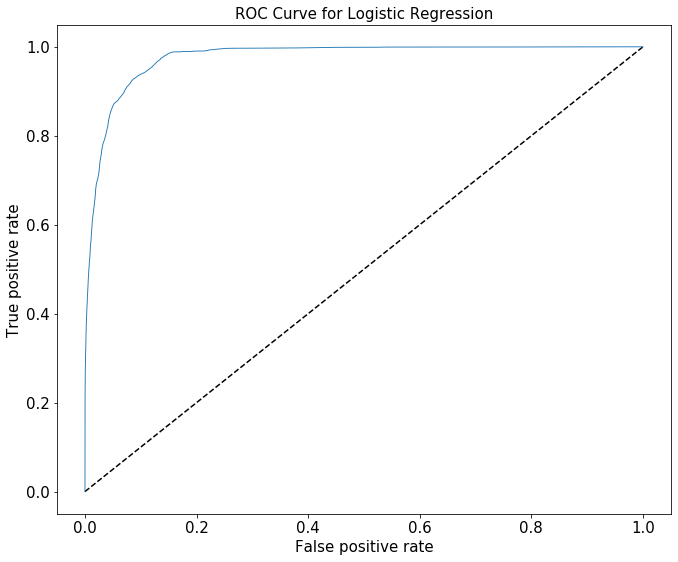

In [33]:
yhat_prob = LR.predict_proba(X_test)
fpr, tpr , _ = roc_curve(y_test, yhat_prob[:,1])
plt.figure(figsize=(11,9))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr,linewidth = 0.9)
plt.xlabel('False positive rate',fontsize=15)
plt.ylabel('True positive rate',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('ROC Curve for Logistic Regression',fontsize=15)
plt.show()

#### Metric 2: Confusion Matrix

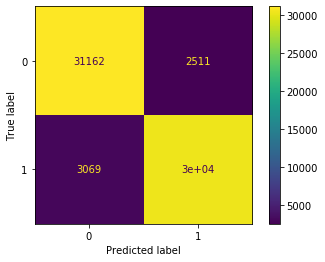

In [34]:
confusion_mat = confusion_matrix(y_test,yhat)
cm_display = ConfusionMatrixDisplay(confusion_mat).plot()
plt.show()

#### Metric 3: Jaccard Score

In [35]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat)

0.8450215247882239

#### Metric 4: Classification Report

In [36]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92     33673
           1       0.92      0.91      0.92     33494

    accuracy                           0.92     67167
   macro avg       0.92      0.92      0.92     67167
weighted avg       0.92      0.92      0.92     67167



#### Metric 5: Log Loss

In [37]:
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

0.22061424683670589

### Model 2: Decision Tree

In [38]:
from sklearn.tree import DecisionTreeClassifier 

We vary the tree depth until we find the classifier with less error and maximum accuracy

#### Metric 1: Accuracy Score

In [39]:
MAX_DEPTH = 30
mean_acc = np.zeros((MAX_DEPTH-1))
mean_error = np.zeros((MAX_DEPTH-1))

for n in range(1,MAX_DEPTH):
    
    #Train Model and Predict 
    DataTree = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    DataTree.fit(X_train,y_train)
    y_hat = DataTree.predict(X_test)
    mean_acc[n-1] = accuracy_score(y_test, y_hat)
    mean_error[n-1] = np.mean(y_hat != y_test)


Minimum Error:  0.07587059121294683
Tree Depth Value:  10


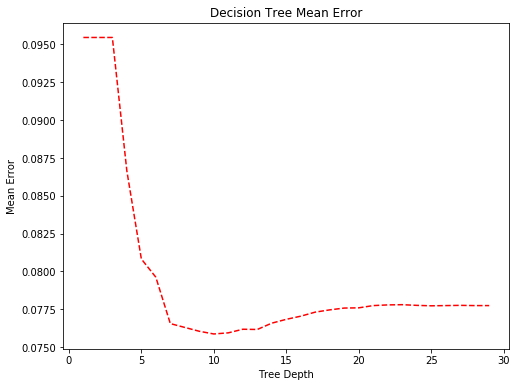

In [40]:
print('Minimum Error: ',min(mean_error))
print('Tree Depth Value: ', list(range(1,MAX_DEPTH))[list(mean_error).index(min(mean_error))])
plt.figure(figsize=(8,6))
plt.plot(range(1,MAX_DEPTH),mean_error, color='red', linestyle='dashed')
plt.title('Decision Tree Mean Error')
plt.xlabel('Tree Depth')
plt.ylabel('Mean Error')
plt.show()

Max Accuracy:  0.9241294087870532
Tree Depth for Max Accuracy:  10


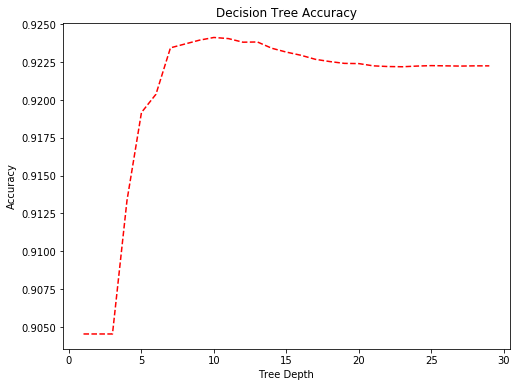

In [41]:
print('Max Accuracy: ',max(mean_acc))
print('Tree Depth for Max Accuracy: ', list(range(1,MAX_DEPTH))[list(mean_acc).index(max(mean_acc))])
plt.figure(figsize=(8,6))
plt.plot(range(1,MAX_DEPTH),mean_acc, color='red', linestyle='dashed')
plt.title('Decision Tree Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.show()

The best tree depth is 10, so to calculate the rest of the metric results we use this value.

#### Metric 2: ROC Curve

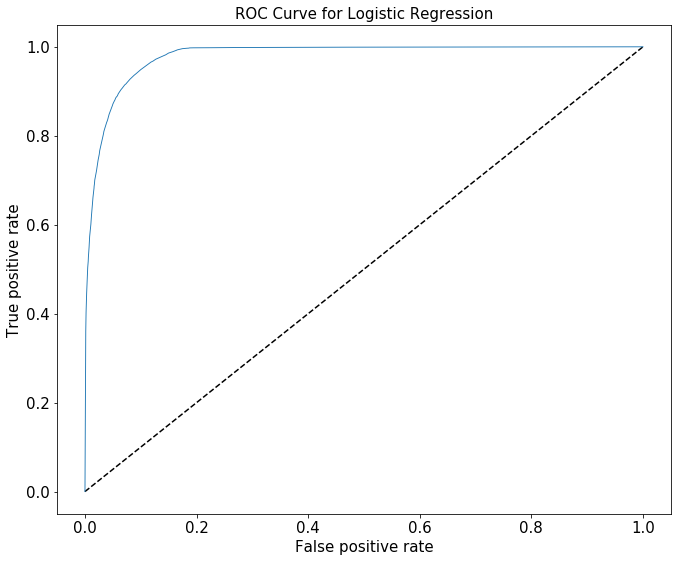

In [42]:
#Train Model and Predict 
DataTreeBest = DecisionTreeClassifier(criterion="entropy", max_depth = 10)
DataTreeBest.fit(X_train,y_train)
y_hat_prob = DataTreeBest.predict_proba(X_test)
fpr_DT, tpr_DT , _ = roc_curve(y_test, y_hat_prob[:,1])
plt.figure(figsize=(11,9))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_DT, tpr_DT , linewidth = 0.9)
plt.xlabel('False positive rate',fontsize=15)
plt.ylabel('True positive rate',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('ROC Curve for Logistic Regression',fontsize=15)
plt.show()

To improve the classifier our second metric to optimize is the area under the ROC curve

In [43]:
from sklearn.metrics import roc_auc_score

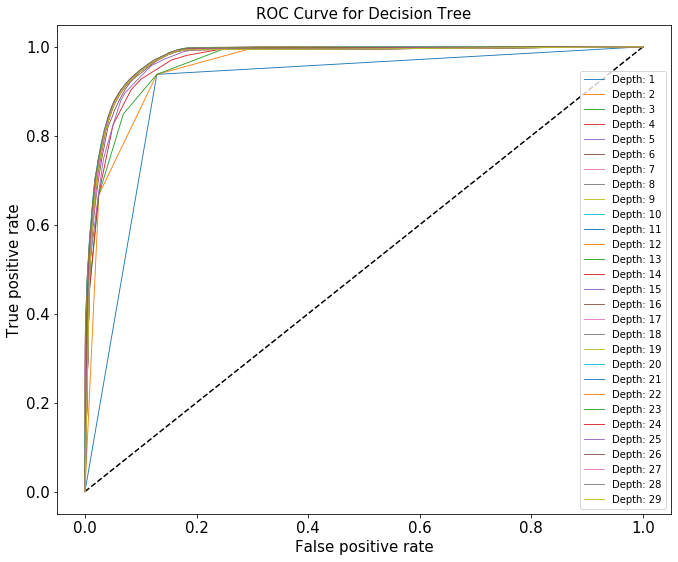

In [44]:
# DataTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

MAX_DEPTH = 30
roc_scores = np.zeros((MAX_DEPTH-1))

plt.figure(figsize=(11,9))
plt.plot([0, 1], [0, 1], 'k--')
for n in range(1,MAX_DEPTH):
    
    #Train Model and Predict 
    DataTreeAux = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    DataTreeAux.fit(X_train,y_train)
    
    y_hat_prob_aux = DataTreeAux.predict_proba(X_test)
    
    fpr_DTaux, tpr_DTaux , _ = roc_curve(y_test, y_hat_prob_aux[:,1])
    roc_scores[n-1] = roc_auc_score(y_test, y_hat_prob_aux[:,1])
    
    plt.plot(fpr_DTaux, tpr_DTaux , linewidth = 0.9 , label = f'Depth: {n}')

plt.xlabel('False positive rate',fontsize=15)
plt.ylabel('True positive rate',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('ROC Curve for Decision Tree',fontsize=15)
plt.legend()
plt.show()


In [45]:
for idx,i in enumerate(roc_scores):
    print(f'Depth: {idx+1}',f'Score: {i}')

print(' ')
print('Best Score: ', max(roc_scores), ' Depth: ', list(range(1,MAX_DEPTH))[list(roc_scores).index(max(roc_scores))])

Depth: 1 Score: 0.9046254470374366
Depth: 2 Score: 0.9570407480005412
Depth: 3 Score: 0.9659857074208051
Depth: 4 Score: 0.9709367100981608
Depth: 5 Score: 0.9739127144046875
Depth: 6 Score: 0.9765114602402155
Depth: 7 Score: 0.9777765750793527
Depth: 8 Score: 0.9784341667797867
Depth: 9 Score: 0.9787861141141234
Depth: 10 Score: 0.9788963044944263
Depth: 11 Score: 0.9786489576689146
Depth: 12 Score: 0.9779134491272159
Depth: 13 Score: 0.977225254332325
Depth: 14 Score: 0.9762966037391455
Depth: 15 Score: 0.9757321025282496
Depth: 16 Score: 0.9749392788518023
Depth: 17 Score: 0.9744282247743348
Depth: 18 Score: 0.9740261428230012
Depth: 19 Score: 0.9739318238828429
Depth: 20 Score: 0.9737605377012861
Depth: 21 Score: 0.9736441469924488
Depth: 22 Score: 0.9735514244617752
Depth: 23 Score: 0.9736023628250638
Depth: 24 Score: 0.9736973321214324
Depth: 25 Score: 0.9735714312275723
Depth: 26 Score: 0.9734152619488253
Depth: 27 Score: 0.9734973331786712
Depth: 28 Score: 0.9735443884676259
De

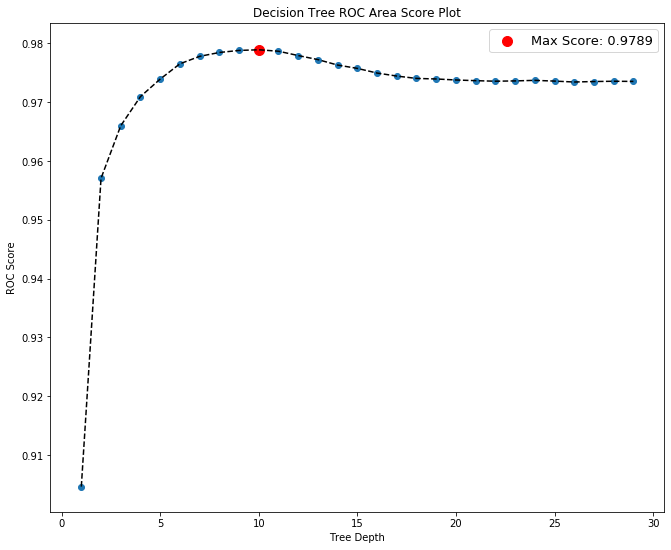

In [119]:
plt.figure(figsize=(11,9))
plt.plot(list(range(1,MAX_DEPTH)), roc_scores ,  'k--')
plt.scatter(list(range(1,MAX_DEPTH)) , roc_scores )
plt.scatter([10],max(roc_scores),s=100,c='r',label="Max Score: %.4f" % max(roc_scores) )
plt.title('Decision Tree ROC Area Score Plot')
plt.xlabel('Tree Depth')
plt.ylabel('ROC Score')
plt.legend(fontsize=13)
plt.show()

#### Metric 3: Confusion Matrix

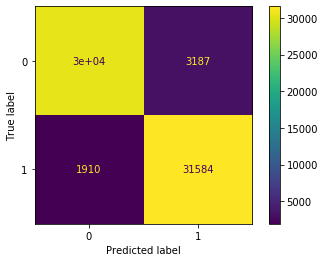

In [47]:
#Train Model and Predict 
DataTreeBest = DecisionTreeClassifier(criterion="entropy", max_depth = 10)
DataTreeBest.fit(X_train,y_train)
y_hat = DataTreeBest.predict(X_test)

confusion_mat = confusion_matrix(y_test,y_hat)
cm_display = ConfusionMatrixDisplay(confusion_mat).plot()
plt.show()

#### Metric 4: Classification Report 

In [48]:
print (classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92     33673
           1       0.91      0.94      0.93     33494

    accuracy                           0.92     67167
   macro avg       0.92      0.92      0.92     67167
weighted avg       0.92      0.92      0.92     67167



### Model 3:  K-Nearest Neighbors

To determine the best classifier we vary the number of neighbors in the model

#### Metric 1: Accuracy Score 

In [49]:
Max_N = 50
error_KNN = np.zeros((Max_N-1))
mean_acc_KNN = np.zeros((Max_N-1))

for i in range(1,Max_N):
    # Create and fit the K Nearest Neighbors model

    knn = KNeighborsClassifier(n_neighbors =  i)
    knn.fit(X_train, y_train)
    # Classification report
    # This takes class predictions hence we'll have to use .predict()
    y_hat_prime = knn.predict(X_test)
    mean_acc_KNN[i-1] = accuracy_score(y_test, y_hat_prime)
    error_KNN[i-1] = np.mean(y_hat_prime != y_test)


Minimum Error:  0.07683832834576504
Number of Neighbors:  37


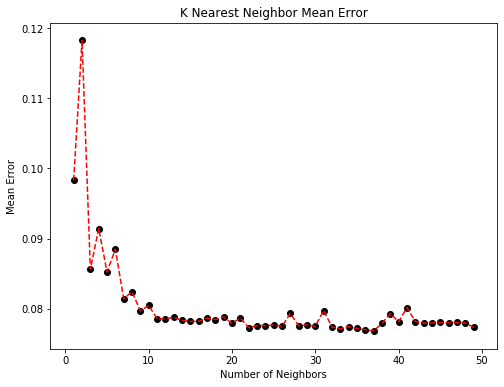

In [50]:
print('Minimum Error: ',min(error_KNN))
print('Number of Neighbors: ', list(range(1,Max_N))[list(error_KNN).index(min(error_KNN))])
plt.figure(figsize=(8,6))
plt.plot(range(1,Max_N),error_KNN, color='red', linestyle='dashed')
plt.scatter(range(1,Max_N),error_KNN,color ='k')
plt.title('K Nearest Neighbor Mean Error')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Error')
plt.show()

Max Accuracy:  0.923161671654235
Number of Neighbors for Max Accuracy:  37


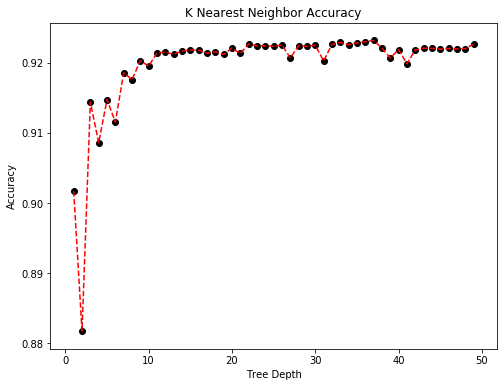

In [51]:
print('Max Accuracy: ',max(mean_acc_KNN))
print('Number of Neighbors for Max Accuracy: ', list(range(1,Max_N))[list(mean_acc_KNN).index(max(mean_acc_KNN))])
plt.figure(figsize=(8,6))
plt.plot(range(1,Max_N),mean_acc_KNN, color='red', linestyle='dashed')
plt.scatter(range(1,Max_N),mean_acc_KNN,color ='k')
plt.title('K Nearest Neighbor Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.show()

For 37 neighbors the error was 0.0768 and the accuracy 0.9231, so to calculate the rest of the metric results we use this value.

#### Metric 2: ROC Curve

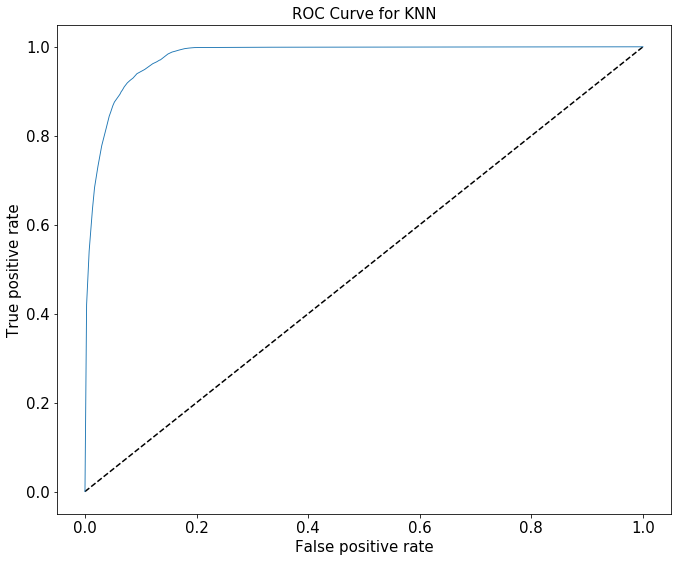

In [52]:
#Train Model and Predict 
KNNBest = KNeighborsClassifier(n_neighbors =  37)
KNNBest.fit(X_train,y_train)
y_hat_prob_KNN = KNNBest.predict_proba(X_test)
fpr_KNN, tpr_KNN , _ = roc_curve(y_test, y_hat_prob_KNN[:,1])
plt.figure(figsize=(11,9))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_KNN, tpr_KNN , linewidth = 0.9)
plt.xlabel('False positive rate',fontsize=15)
plt.ylabel('True positive rate',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('ROC Curve for KNN',fontsize=15)
plt.show()

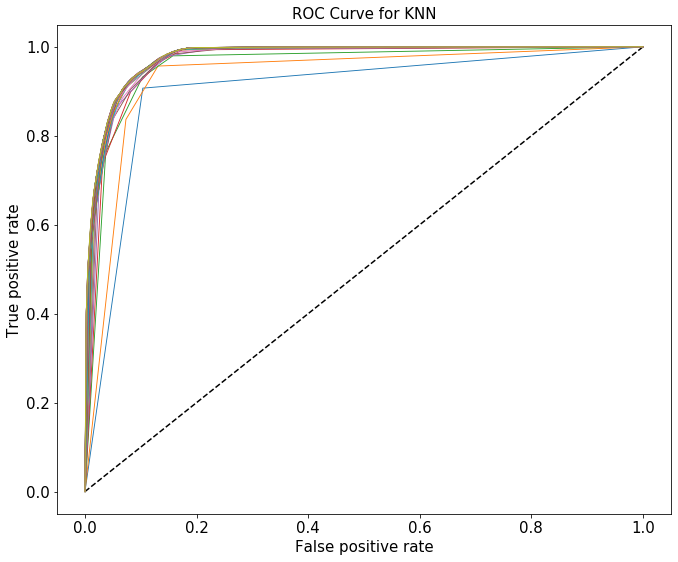

In [53]:
MAX_NEIGHBORS = 50
roc_scoresKNN = np.zeros((MAX_NEIGHBORS-1))

plt.figure(figsize=(11,9))
plt.plot([0, 1], [0, 1], 'k--')
for n in range(1,MAX_NEIGHBORS):
    
    #Train Model and Predict 
    KNNAux = KNeighborsClassifier(n_neighbors = n)
    KNNAux.fit(X_train,y_train)
    
    y_hat_prob_aux_KNN = KNNAux.predict_proba(X_test)
    
    fpr_KNNaux, tpr_KNNaux , _ = roc_curve(y_test, y_hat_prob_aux_KNN[:,1])
    roc_scoresKNN[n-1] = roc_auc_score(y_test,y_hat_prob_aux_KNN[:,1])
    
    plt.plot(fpr_KNNaux, tpr_KNNaux , linewidth = 0.9 )

plt.xlabel('False positive rate',fontsize=15)
plt.ylabel('True positive rate',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('ROC Curve for KNN',fontsize=15)
plt.show()


In [54]:
for idx,i in enumerate(roc_scoresKNN):
    print(f'Num of Neighbors: {idx+1}',f'Score: {i}')

print(' ')
print('Best Score: ', max(roc_scoresKNN), ' Depth: ', list(range(1,MAX_NEIGHBORS))[list(roc_scoresKNN).index(max(roc_scoresKNN))])

Num of Neighbors: 1 Score: 0.9017070557793418
Num of Neighbors: 2 Score: 0.9325671517702162
Num of Neighbors: 3 Score: 0.9559509979231497
Num of Neighbors: 4 Score: 0.9637835343500887
Num of Neighbors: 5 Score: 0.9668443780011023
Num of Neighbors: 6 Score: 0.9680541004013906
Num of Neighbors: 7 Score: 0.9696270097277028
Num of Neighbors: 8 Score: 0.9708676690453697
Num of Neighbors: 9 Score: 0.9719137344256733
Num of Neighbors: 10 Score: 0.9722114526031629
Num of Neighbors: 11 Score: 0.9730159600818789
Num of Neighbors: 12 Score: 0.9733824745973481
Num of Neighbors: 13 Score: 0.9741378764139168
Num of Neighbors: 14 Score: 0.9744566582414607
Num of Neighbors: 15 Score: 0.9748008682431853
Num of Neighbors: 16 Score: 0.9750783899122342
Num of Neighbors: 17 Score: 0.9754583912284096
Num of Neighbors: 18 Score: 0.9756448426350854
Num of Neighbors: 19 Score: 0.9758522530673677
Num of Neighbors: 20 Score: 0.9759521867051439
Num of Neighbors: 21 Score: 0.9760556571812623
Num of Neighbors: 22 S

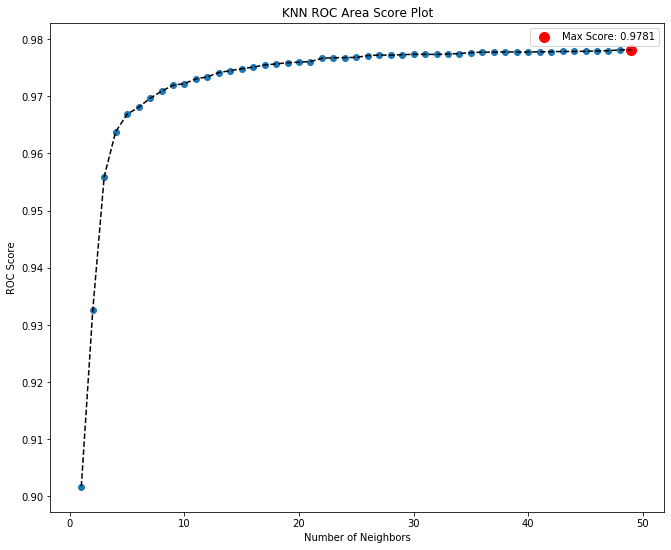

In [55]:
plt.figure(figsize=(11,9))
plt.plot(list(range(1,MAX_NEIGHBORS)), roc_scoresKNN ,  'k--')
plt.scatter(list(range(1,MAX_NEIGHBORS)) , roc_scoresKNN )
plt.scatter([49],max(roc_scoresKNN),s=100,c='r',label="Max Score: %.4f" % max(roc_scoresKNN) )
plt.title('KNN ROC Area Score Plot')
plt.xlabel('Number of Neighbors')
plt.ylabel('ROC Score')
plt.legend()
plt.show()

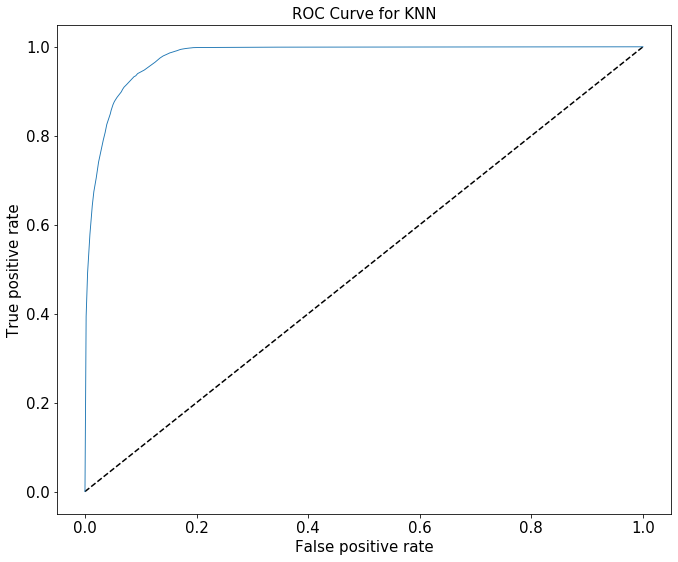

In [56]:
#Train Model and Predict 
KNNBest = KNeighborsClassifier(n_neighbors =  49)
KNNBest.fit(X_train,y_train)
y_hat_prob_KNN = KNNBest.predict_proba(X_test)
fpr_KNN, tpr_KNN , _ = roc_curve(y_test, y_hat_prob_KNN[:,1])
plt.figure(figsize=(11,9))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_KNN, tpr_KNN , linewidth = 0.9)
plt.xlabel('False positive rate',fontsize=15)
plt.ylabel('True positive rate',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('ROC Curve for KNN',fontsize=15)
plt.show()

#### Metric 3: Confusion Matrix

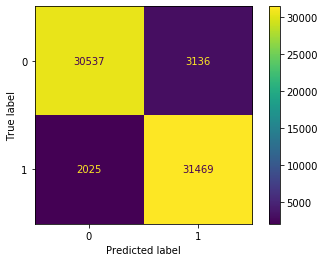

In [57]:
#Train Model and Predict 
KNNBest = KNeighborsClassifier(n_neighbors =  37)
KNNBest.fit(X_train,y_train)
y_hat = KNNBest.predict(X_test)

confusion_mat = confusion_matrix(y_test,y_hat)
cm_display = ConfusionMatrixDisplay(confusion_mat).plot()
plt.show()

#### Metric 4: Classification Report 

In [58]:
print (classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92     33673
           1       0.91      0.94      0.92     33494

    accuracy                           0.92     67167
   macro avg       0.92      0.92      0.92     67167
weighted avg       0.92      0.92      0.92     67167



When optimizing the accuracy the best number of neighbors is 37. When optimizing the ROC curve area is 49.

### Model 4: Support Vector Machine

This model depends on the C parameter, its a continuous variable between 0 and 1, smaller the value, the better the predictions 

In [59]:
from sklearn import svm

clf_SVM = svm.SVC(C=1,kernel='rbf',probability=True)
clf_SVM.fit(X_train, y_train)
clf_SVM

KeyboardInterrupt: 

In [ ]:
C_Values = np.linspace(0.1,1,30)
C_Values

In [ ]:
# Predicion:
yhat_SVM = clf_SVM.predict(X_test)
yhat_SVM[:50]

In [ ]:
yhat_prob_SVM = clf_SVM.predict_proba(X_test)
fpr_SVM, tpr_SVM , _ = roc_curve(y_test, yhat_prob_SVM[:,1])
plt.figure(figsize=(11,9))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_SVM, tpr_SVM ,linewidth = 0.9)
plt.xlabel('False positive rate',fontsize=15)
plt.ylabel('True positive rate',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('ROC Curve for Logistic Regression',fontsize=15)
plt.show()

In [ ]:
confusion_mat = confusion_matrix(y_test,yhat_SVM)
cm_display = ConfusionMatrixDisplay(confusion_mat).plot()
plt.show()

In [ ]:
print (classification_report(y_test, yhat_SVM))

## 4. Create the unsupervised models classifiers 

## Second approach 

#### The second approach consists in developing an unsupervisted learning algorithm to determine if certain caracteristics of the cluster coincide with the real values.

### Model 1: K-Means 

In [60]:
from sklearn.cluster import KMeans 

We use the parameters data to determine the two types of classes

In [61]:
parameters_data

,ClusterMaxEnergies,ClusterMeanEnergies,ClustersArea,ClusterTotalEnergies
0,7.0,6.333333,3,19.0
1,9.0,7.500000,4,30.0
2,7.0,6.333333,3,19.0
3,16.0,9.333333,3,28.0
4,19.0,13.250000,4,53.0
...,...,...,...,...
2979816,8.0,5.000000,4,20.0
2979817,5.0,4.750000,4,19.0
2979818,6.0,4.750000,4,19.0
2979819,5.0,4.250000,4,17.0


We try to predict the classes or target

In [62]:
target

0          1
1          1
2          1
3          1
4          1
          ..
2979816    0
2979817    0
2979818    0
2979819    0
2979820    0
Name: Class, Length: 335834, dtype: int32

In [63]:
parameters_data_array = parameters_data.to_numpy()
parameters_data_array

array([[ 7.        ,  6.33333333,  3.        , 19.        ],
       [ 9.        ,  7.5       ,  4.        , 30.        ],
       [ 7.        ,  6.33333333,  3.        , 19.        ],
       ...,
       [ 6.        ,  4.75      ,  4.        , 19.        ],
       [ 5.        ,  4.25      ,  4.        , 17.        ],
       [ 7.        ,  5.66666667,  3.        , 17.        ]])

Predict the classes:

In [64]:
k_means = KMeans(init = "k-means++", n_clusters = 2, n_init = 22) # 2 Clusters and 12 iterations of the clusters centers

In [65]:
k_means.fit(parameters_data_array) #Fit the data to the k_means algorithm

KMeans(n_clusters=2, n_init=22)

In [66]:
k_means_labels = k_means.labels_ # Extract the labels
k_means_labels

array([0, 0, 0, ..., 0, 0, 0])

In [67]:
target_array = target.to_numpy()
target_array

array([1, 1, 1, ..., 0, 0, 0])

Compare the coincidences

In [68]:
results_confusion_matrix = confusion_matrix(target_array,k_means_labels)
print(results_confusion_matrix)

[[167891     26]
 [158678   9239]]


In [69]:
def confusion_matrix_aux(expected_array,predicted_array):
    labels1 = list(set(expected_array))
    labels2 = list(set(predicted_array))
    
    masked = (expected_array == predicted_array)
    masked1 = (expected_array != predicted_array) 
    
    conf_matrix = np.zeros((2,2),dtype=int)
    conf_matrix[0][0] = list(k_means_labels[masked]).count(labels1[0])
    conf_matrix[1][1] = list(k_means_labels[masked]).count(labels1[1])
    conf_matrix[1][0] = list(k_means_labels[masked1]).count(labels1[0])
    conf_matrix[0][1] = list(k_means_labels[masked1]).count(labels1[1])
    
    return conf_matrix

print(confusion_matrix_aux(target_array,k_means_labels))

[[167891     26]
 [158678   9239]]


In [1]:
cm_display = ConfusionMatrixDisplay(results_confusion_matrix).plot()
plt.show()

NameError: name 'ConfusionMatrixDisplay' is not defined

In [71]:
k_means_labels

array([0, 0, 0, ..., 0, 0, 0])

In [72]:
list(k_means_labels).count(1)

9265

In [73]:
parameters_data_array

array([[ 7.        ,  6.33333333,  3.        , 19.        ],
       [ 9.        ,  7.5       ,  4.        , 30.        ],
       [ 7.        ,  6.33333333,  3.        , 19.        ],
       ...,
       [ 6.        ,  4.75      ,  4.        , 19.        ],
       [ 5.        ,  4.25      ,  4.        , 17.        ],
       [ 7.        ,  5.66666667,  3.        , 17.        ]])

In [74]:
Label0 = (k_means_labels==0)
list(Label0).count(False)

9265

In [75]:
parameters_data_array[:,0][~Label0]

array([116., 102., 103., ...,  13.,  24.,  13.])

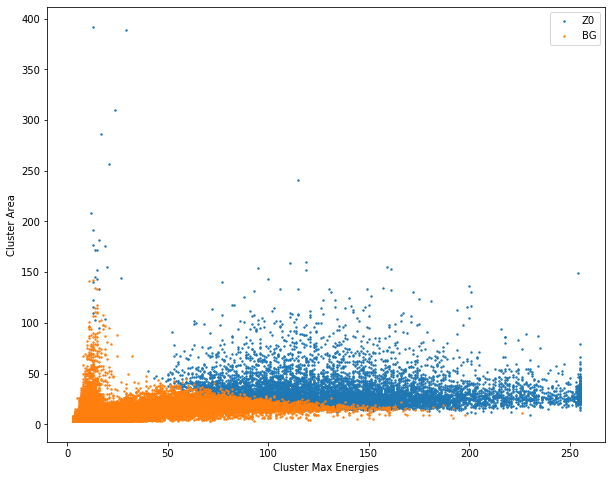

In [76]:
plt.figure(figsize=(10,8))
plt.scatter(parameters_data_array[:,0][~Label0], parameters_data_array[:,2][~Label0] , label = 'Z0',s=2)
plt.scatter(parameters_data_array[:,0][Label0],parameters_data_array[:,2][Label0], label = 'BG',s=2)
plt.xlabel('Cluster Max Energies')
plt.ylabel('Cluster Area')
plt.legend()
plt.show()

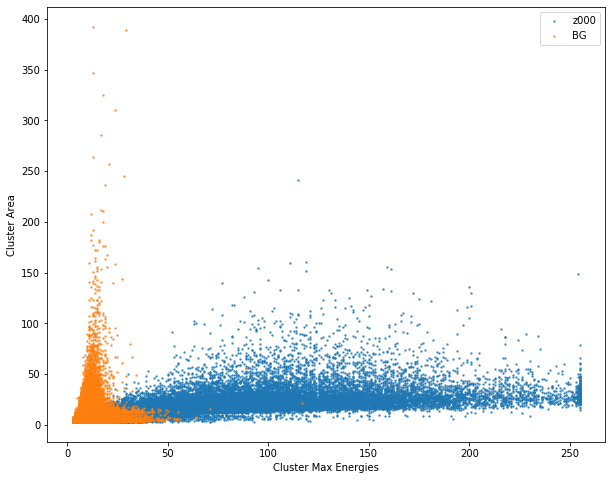

In [77]:
plt.figure(figsize=(10,8))
indexes = range(len(zetas))
for idx,TotalE,AreaC,Zet in zip(indexes,flatten_data_dictionary['ClusterMaxEnergies'],flatten_data_dictionary['ClustersArea'],zetas):
    
    if idx == 0 or idx == 10:
#         break
        plt.scatter(TotalE,AreaC,s=2,label=Zet,alpha = 0.7)

plt.xlabel('Cluster Max Energies')
plt.ylabel('Cluster Area')
plt.legend()
plt.show()

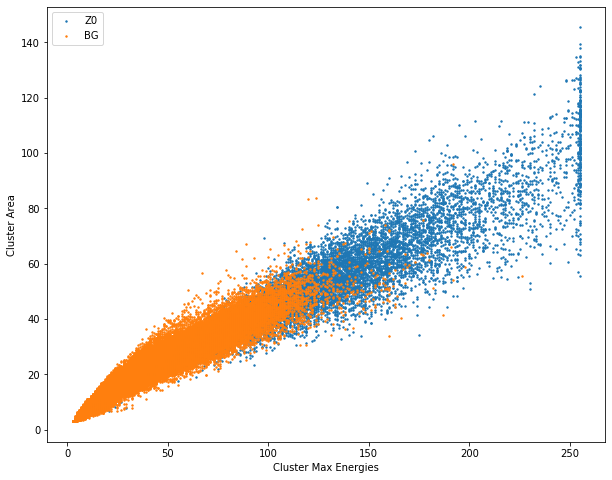

In [78]:
plt.figure(figsize=(10,8))
plt.scatter(parameters_data_array[:,0][~Label0], parameters_data_array[:,1][~Label0] , label = 'Z0',s=2)
plt.scatter(parameters_data_array[:,0][Label0],parameters_data_array[:,1][Label0], label = 'BG',s=2)
plt.xlabel('Cluster Max Energies')
plt.ylabel('Cluster Area')
plt.legend()
plt.show()

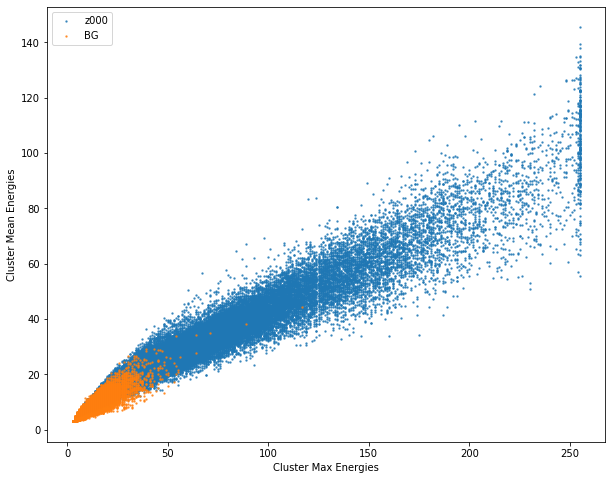

In [79]:
plt.figure(figsize=(10,8))
indexes = range(len(zetas))
for idx,TotalE,AreaC,Zet in zip(indexes,flatten_data_dictionary['ClusterMaxEnergies'],flatten_data_dictionary['ClusterMeanEnergies'],zetas):
    
    if idx == 0 or idx == 10:
#         break
        plt.scatter(TotalE,AreaC,s=2,label=Zet,alpha = 0.7)

plt.xlabel('Cluster Max Energies')
plt.ylabel('Cluster Mean Energies')
plt.legend()
plt.show()

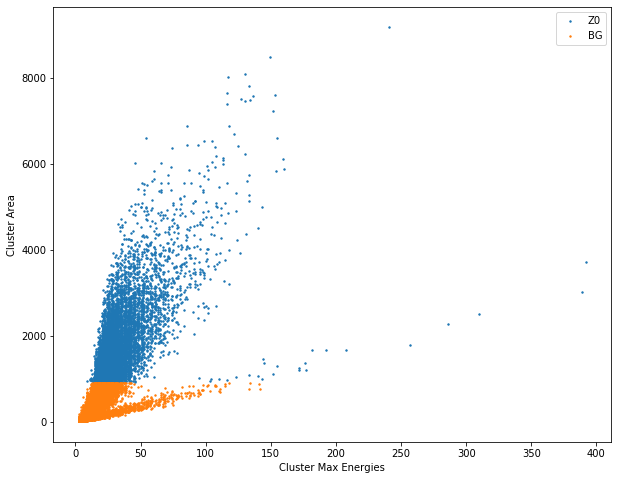

In [80]:
plt.figure(figsize=(10,8))
plt.scatter(parameters_data_array[:,2][~Label0], parameters_data_array[:,3][~Label0] , label = 'Z0',s=2)
plt.scatter(parameters_data_array[:,2][Label0],parameters_data_array[:,3][Label0], label = 'BG',s=2)
plt.xlabel('Cluster Max Energies')
plt.ylabel('Cluster Area')
plt.legend()
plt.show()

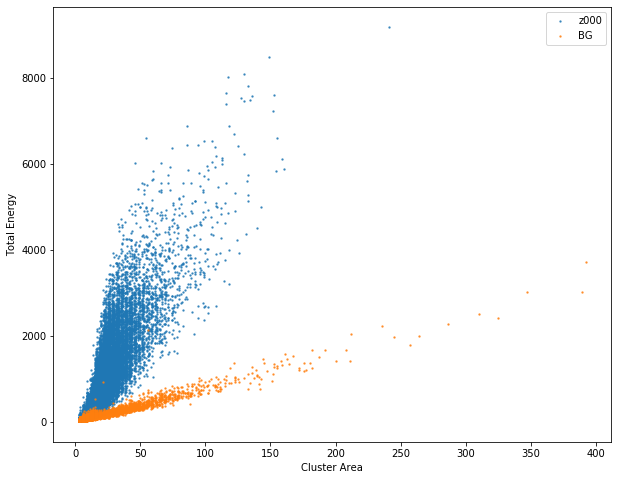

In [81]:
plt.figure(figsize=(10,8))
indexes = range(len(zetas))
for idx,TotalE,AreaC,Zet in zip(indexes,flatten_data_dictionary['ClustersArea'],flatten_data_dictionary['ClusterTotalEnergies'],zetas):
    
    if idx == 0 or idx == 10:
#         break
        plt.scatter(TotalE,AreaC,s=2,label=Zet,alpha = 0.7)

plt.xlabel('Cluster Area')
plt.ylabel('Total Energy')
plt.legend()
plt.show()

To solve the problem let's train the model with all the BG and Z0 data

In [82]:
data_frame_complete = data_frame.drop(data_frame.index[indices_list[0]:indices_list[1]])
data_frame_complete

,Class,ClusterMaxEnergies,ClusterMeanEnergies,ClustersArea,ClusterTotalEnergies
0,z0,7.0,6.333333,3,19.0
1,z0,9.0,7.500000,4,30.0
2,z0,7.0,6.333333,3,19.0
3,z0,16.0,9.333333,3,28.0
4,z0,19.0,13.250000,4,53.0
...,...,...,...,...,...
3255354,BG,11.0,8.666667,3,26.0
3255355,BG,8.0,7.500000,4,30.0
3255356,BG,14.0,9.000000,8,72.0
3255357,BG,9.0,7.333333,3,22.0


In [83]:
data_frame_complete.set_index(["ClustersArea","Class","ClusterMaxEnergies","ClusterTotalEnergies"]).count(level="Class")

,ClusterMeanEnergies
Class,
BG,443455
z0,167917


In [84]:
DF_Encoder(data_frame_complete,'Class')
data_frame_complete

,Class,ClusterMaxEnergies,ClusterMeanEnergies,ClustersArea,ClusterTotalEnergies
0,1,7.0,6.333333,3,19.0
1,1,9.0,7.500000,4,30.0
2,1,7.0,6.333333,3,19.0
3,1,16.0,9.333333,3,28.0
4,1,19.0,13.250000,4,53.0
...,...,...,...,...,...
3255354,0,11.0,8.666667,3,26.0
3255355,0,8.0,7.500000,4,30.0
3255356,0,14.0,9.000000,8,72.0
3255357,0,9.0,7.333333,3,22.0


In [85]:
# Separate data 

# Separate Parameters (input data) and Target(Classes or output data)
parameters_data_complete = data_frame_complete.iloc[:,1:] # Parameters data
target_complete = data_frame_complete['Class'] # Classes data

print(parameters_data_complete.shape)
print(target_complete.shape)


(611372, 4)
(611372,)


In [86]:
parameters_data_array_comp = parameters_data_complete.to_numpy()
parameters_data_array_comp

array([[ 7.        ,  6.33333333,  3.        , 19.        ],
       [ 9.        ,  7.5       ,  4.        , 30.        ],
       [ 7.        ,  6.33333333,  3.        , 19.        ],
       ...,
       [14.        ,  9.        ,  8.        , 72.        ],
       [ 9.        ,  7.33333333,  3.        , 22.        ],
       [13.        , 10.        ,  3.        , 30.        ]])

In [87]:
k_means2 = KMeans(init = "k-means++", n_clusters = 2, n_init = 22) # 2 Clusters and 12 iterations of the clusters centers

In [88]:
k_means2.fit(parameters_data_array_comp) #Fit the data to the k_means algorithm

KMeans(n_clusters=2, n_init=22)

In [100]:
k_means_labels2 = k_means2.labels_ # Extract the labels
# k_means_labels2new = 1-k_means_labels2
k_means_labels2

array([0, 0, 0, ..., 0, 0, 0])

In [101]:
target_array_comp = target_complete.to_numpy()
target_array_comp

array([1, 1, 1, ..., 0, 0, 0])

In [103]:
results_confusion_matrix2 = confusion_matrix(target_array_comp,k_means_labels2)
print(results_confusion_matrix2)

[[443380     75]
 [158200   9717]]


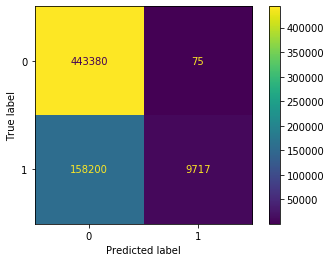

In [104]:
cm_display = ConfusionMatrixDisplay(results_confusion_matrix2).plot()
plt.show()

In [105]:
Label02 = (k_means_labels2==0)
list(Label02).count(False)

9792

In [106]:
Label02

array([ True,  True,  True, ...,  True,  True,  True])

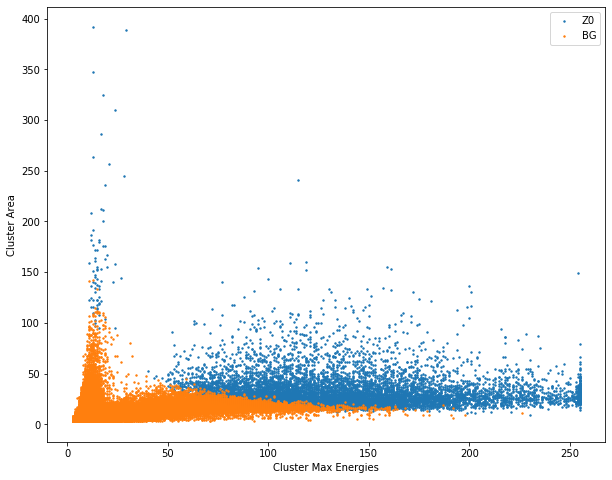

In [107]:
plt.figure(figsize=(10,8))
plt.scatter(parameters_data_array_comp[:,0][~Label02],parameters_data_array_comp[:,2][~Label02], label = 'Z0',s=2)
plt.scatter(parameters_data_array_comp[:,0][Label02], parameters_data_array_comp[:,2][Label02] , label = 'BG',s=2)
plt.xlabel('Cluster Max Energies')
plt.ylabel('Cluster Area')
plt.legend()
plt.show()

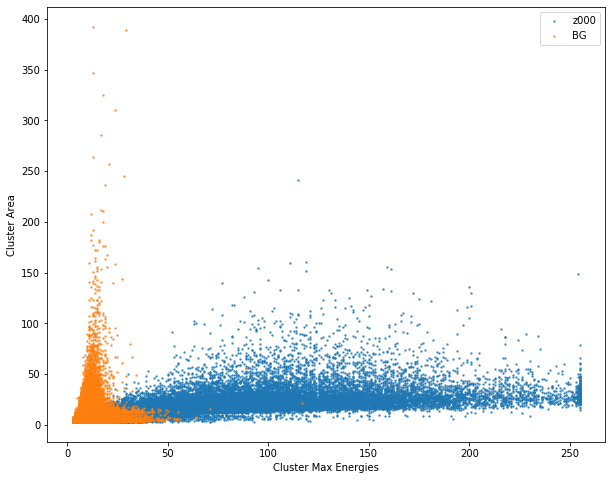

In [96]:
plt.figure(figsize=(10,8))
indexes = range(len(zetas))
for idx,TotalE,AreaC,Zet in zip(indexes,flatten_data_dictionary['ClusterMaxEnergies'],flatten_data_dictionary['ClustersArea'],zetas):
    
    if idx == 0 or idx == 10:
#         break
        plt.scatter(TotalE,AreaC,s=2,label=Zet,alpha = 0.7)

plt.xlabel('Cluster Max Energies')
plt.ylabel('Cluster Area')
plt.legend()
plt.show()

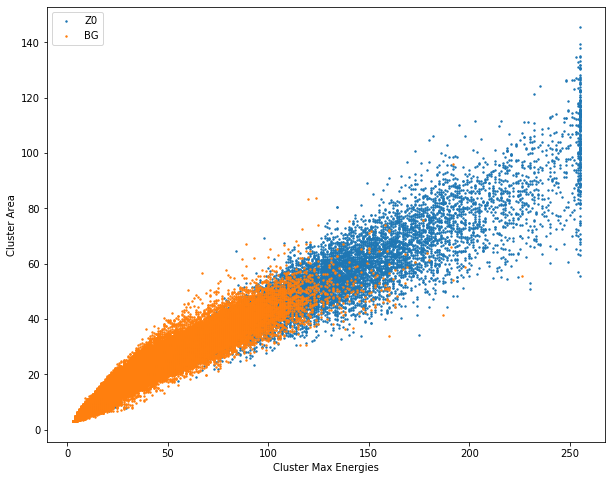

In [108]:
plt.figure(figsize=(10,8))
plt.scatter(parameters_data_array_comp[:,0][~Label02],parameters_data_array_comp[:,1][~Label02], label = 'Z0',s=2)
plt.scatter(parameters_data_array_comp[:,0][Label02], parameters_data_array_comp[:,1][Label02] , label = 'BG',s=2)
plt.xlabel('Cluster Max Energies')
plt.ylabel('Cluster Area')
plt.legend()
plt.show()

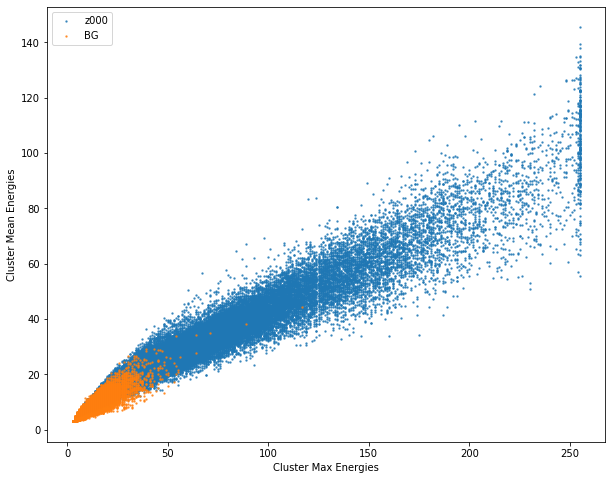

In [109]:
plt.figure(figsize=(10,8))
indexes = range(len(zetas))
for idx,TotalE,AreaC,Zet in zip(indexes,flatten_data_dictionary['ClusterMaxEnergies'],flatten_data_dictionary['ClusterMeanEnergies'],zetas):
    
    if idx == 0 or idx == 10:
#         break
        plt.scatter(TotalE,AreaC,s=2,label=Zet,alpha = 0.7)

plt.xlabel('Cluster Max Energies')
plt.ylabel('Cluster Mean Energies')
plt.legend()
plt.show()

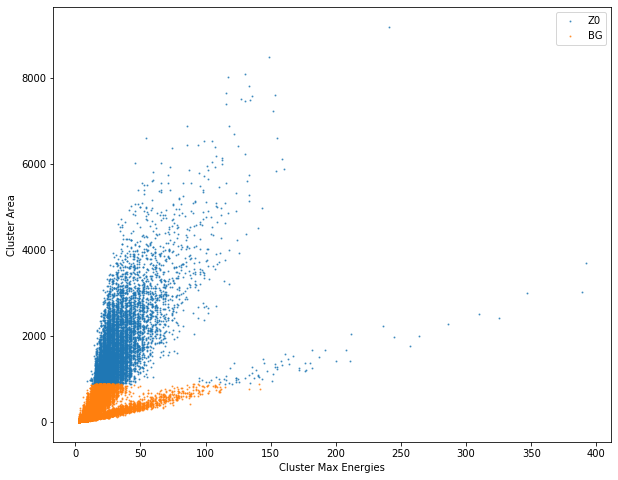

In [110]:
plt.figure(figsize=(10,8))
plt.scatter(parameters_data_array_comp[:,2][~Label02],parameters_data_array_comp[:,3][~Label02], label = 'Z0',s=1,alpha=0.7)
plt.scatter(parameters_data_array_comp[:,2][Label02], parameters_data_array_comp[:,3][Label02] , label = 'BG',s=1,alpha=0.7)
plt.xlabel('Cluster Max Energies')
plt.ylabel('Cluster Area')
plt.legend()
plt.show()

### Model 2: DBSCAN

Import necessary libraries

In [ ]:
from scipy import ndimage 
from scipy.cluster import hierarchy
from scipy.spatial import distance_matrix  
from sklearn import manifold, datasets
from sklearn.cluster import DBSCAN

In [ ]:
epsilon = 0.3
minimumSamples = 7
db = DBSCAN(eps=epsilon, min_samples=minimumSamples).fit(parameters_data_array_comp)
labels = db.labels_
labels

In [ ]:
set(labels)

## 4. Use the clusters total array to train the models

In [114]:
data_dictionary['ClustersImages'].shape

(11, 500)